In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [29]:
print(movies)

      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                  

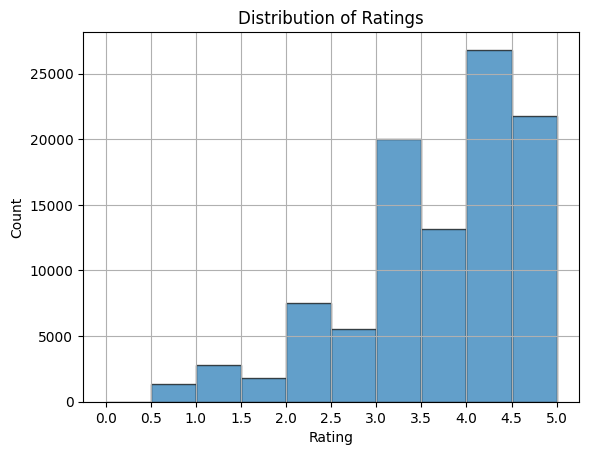

In [30]:
# Number of total ratings
total_ratings = ratings.shape[0]

# Number of videos in the database
num_videos = len(movies['movieId'].unique())

# Number of users
num_users = len(ratings['userId'].unique())

# Average number of ratings per user
avg_ratings_per_user = total_ratings / num_users

# Average number of ratings per video
avg_ratings_per_video = total_ratings / num_videos
# Distribution of ratings

# Distribution of ratings
rating_distribution = ratings['rating'].value_counts().sort_index()

# Creating bins for the distribution
bins = [i / 2 for i in range(0, 11)]  # Bins from 0 to 5 in intervals of 0.5

# Plotting distribution of ratings
plt.hist(ratings['rating'], bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.xticks(bins)
plt.grid(True)
plt.show()


In [31]:
movie_titles = dict(zip(movies['movieId'], movies['title']))


In [32]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C * m + ratings.sum()) / (C + ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']

movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')


In [33]:
from scipy.sparse import csr_matrix

def create_sparse(df):
    M = df['userId'].nunique()
    N = df['movieId'].nunique()
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]
    X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper


In [34]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse(ratings)
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz  # Number of stored values, including explicit 0s
sparsity = n_ratings / n_total
sparsity_p = round(sparsity * 100, 2)
print(f"Matrix sparsity: {sparsity_p}%")
n_ratings_per_user = X.getnnz(axis=1)


Matrix sparsity: 1.7%


In [39]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)
    kNN = NearestNeighbors(n_neighbors=k + 1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(1, k + 1):  # Start from 1 to exclude the movie itself
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    return neighbour_ids


In [44]:
# Assuming you have loaded your dataset and created the necessary mappings

# Get the first movie ID
first_movie_id = movies['movieId'].iloc[0]

# Find similar movies to the first movie
similar_movies = find_similar_movies(first_movie_id, X, movie_mapper, movie_inv_mapper, k=10)

# Print the recommendations
print("Recommendations for the first movie:")
for movie_id in similar_movies:
    movie_title = movie_titles.get(movie_id, "Unknown")  # Get the title or return "Unknown" if not found
    print(movie_title)



Recommendations for the first movie:
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)
